In [250]:
from os.path import join
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

---

## Functions

I/O

In [251]:
def read_trace(filepath):
    df = pd.read_csv(filepath, sep='\t', lineterminator = '\n', engine='c', keep_default_na=False)
    df = df.rename(columns={df.columns[-1]: df.columns[-1][:-1]})
    df = rename_trace_columns(df)
    return df

In [325]:
def rename_trace_columns(df):
    
    # always replace these columns
    dict_rename = {'time (s)': 't', 
                   'Running?': 'running?',
                   'Step number': 'step',
                   'Master timer (s)': 'tm'}
    
    # programmatically replace these columns
    col_V, col_I = 'Ch. {} Voltage (V)', 'Ch. {} Current (uA)'
    V, I = 'V{}', 'I{}'
    
    channels = ['A', 'B', 'C', 'D']
    
    for c in channels:
        if col_V.format(c) in df.columns:
            dict_rename.update({col_V.format(c): V.format(c.lower()),
                                col_I.format(c): I.format(c.lower())})
    
    df = df.rename(columns=dict_rename)
    
    return df

In [326]:
def export_settings(id_, t_dwell, t_step, t_pause, path_save):
    dict_ = {
        'test_id': id_,
        't_dwell': t_dwell,
        't_step': t_step,
        't_pause': t_pause,
    }

    df = pd.DataFrame.from_dict(dict_, orient='index')
    df.to_excel(path_save)

---

Splicing cycles

In [406]:
def get_sequence(df, sampling_period=0.0256):
    """ 
    I generally set the sampling period to 0.0256 s (25.6 ms). 
        > I wonder if shorter sampling periods would get more precise measurements?
    """
    # 1. get reduced dataframe
    dff = df[['t', 'running?', 'step', 'tm']]

    # 2. get first time point of first pass through each step   
    t_i_step1_idx = dff[dff['step'] == 1]['t'].idxmin()
    t_i_step1 = dff[dff['step'] == 1]['t'].min()
    
    t_i_step2_idx = dff[dff['step'] == 2]['t'].idxmin()
    t_i_step2 = dff[dff['step'] == 2]['t'].min()
    
    t_i_step3_idx = dff[dff['step'] == 3]['t'].idxmin()
    t_i_step3 = dff[dff['step'] == 3]['t'].min()
    
    t_i_step4_idx = dff[dff['step'] == 4]['t'].idxmin()
    t_i_step4 = dff[dff['step'] == 4]['t'].min()

    # 3. get the last time point of the first pass through a cycle
    dff_ = dff.iloc[t_i_step4_idx:]
    t_ip1_step1_idx = dff_[dff_['step'] == 1]['t'].idxmin()

    # 4. cut out the dataframe with all rows from the first cycle
    dff_ = df.iloc[t_i_step1_idx:t_ip1_step1_idx]
    
    # 5. calculate the actual sampling rate
    dt = dff_['t'].diff().mean()
    
    # 6. reset index and reset first time point to t = 0 + dt
    dff_ = dff_.reset_index()
    dff_['t'] = dff_['t'] - dff_['t'].iloc[0] + sampling_period
    
    # outputs
    dict_sequence = {
        'df': dff_,
        'dt': np.round(dt, 3),
        't_i': 0,
        't_f': np.round(dff_['t'].iloc[-1], 3),
        't_1_i': 0,
        't_1_f': np.round(dff_['t'].iloc[t_i_step2_idx - t_i_step1_idx - 1], 3),
        't_2_i': np.round(dff_['t'].iloc[t_i_step2_idx - t_i_step1_idx - 1], 3),
        't_2_f': np.round(dff_['t'].iloc[t_i_step3_idx - t_i_step1_idx - 1], 3),
        't_3_i': np.round(dff_['t'].iloc[t_i_step3_idx - t_i_step1_idx - 1], 3),
        't_3_f': np.round(dff_['t'].iloc[t_i_step4_idx - t_i_step1_idx - 1], 3),
        't_4_i': np.round(dff_['t'].iloc[t_i_step4_idx - t_i_step1_idx - 1], 3),
        't_4_f': np.round(dff_['t'].iloc[t_ip1_step1_idx - t_i_step1_idx - 1], 3),
    }
    
    return dict_sequence

---

Plotting

In [375]:
# INPUTS
figsize0 = (6.25, 3.5)
figsize1 = (5.75, 3)
figsize3 = (5, 3.5)
figsize4 = (6.5, 5)
fontsize = 16

In [395]:
def plot_trace(df, dict_seq, path_save=None):
    channels = [x[1] for x in df.columns if x.startswith('V')]
    channel_clrs = ['r', 'k', 'b', 'gray']
    channel_mrks = ['.', 'v', '^', 'o']
    channel_ls = ['--', '-', '-', '-']

    steps = df['step'].unique()
    step_clrs = ['g', 'r', 'g', 'r']
    step_lbls = ['1: +V', '2: OFF', '3: -V', '4: OFF']

    # ---
    
    px = 't'
    py = 'V{}'

    fig, ax = plt.subplots(figsize=figsize0)

    # Repeat plotting 2X to correct legend and zorder for Jupyter inadequacies
    for c, clr, mrk, ls in zip(channels, channel_clrs, channel_mrks, channel_ls):
        ax.plot(df[px], df[py.format(c)],
                marker=mrk, color=clr, linestyle=ls,
                label='Ch. {}'.format(c))
    
    channels.reverse()
    channel_clrs.reverse()
    channel_mrks.reverse()
    channel_ls.reverse()
    for c, clr, mrk, ls in zip(channels, channel_clrs, channel_mrks, channel_ls):
        ax.plot(df[px], df[py.format(c)],
                marker=mrk, color=clr, linestyle=ls)

    if dict_seq is not None:
        for s in steps:
            ax.axvspan(dict_seq['t_{}_i'.format(s)], dict_seq['t_{}_f'.format(s)],
                      color=step_clrs[s-1], alpha=0.05, edgecolor=None,
                      label=step_lbls[s-1])

    ax.set_xlabel(r'$t \: (s)$', fontsize=fontsize)
    ax.set_ylabel(r'$V_{channel} \: (V)$', fontsize=fontsize)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(alpha=0.25)
    plt.tight_layout()
    if path_save is not None:
        plt.savefig(path_save, dpi=300, facecolor='white')
    plt.show()

def plot_overlay_ideal_trace(df, path_save=None):
    channels = [x[1] for x in df.columns if x.startswith('V') and x != 'Vd']
    channel_clrs = ['r', 'k', 'b']
    channel_mrks = ['.', 'v', '^']
    channel_ls = ['--', '-', '-']
    channel_lbls = [r'$\widetilde{V_{A}}$', r'$\widetilde{V_{B}}$', r'$\widetilde{V_{C}}$']
    
    px = 't'
    py = 'V{}'
    
    fig, ax = plt.subplots(figsize=figsize1)
        
    for c, clr, mrk, ls, channel_lbl in zip(channels, channel_clrs, channel_mrks, channel_ls, channel_lbls):
        ax.plot(df[px], df[py.format(c)],
                marker=mrk, color=clr, linestyle=ls,
                label='Ch. {}'.format(c))
    
    channels.reverse()
    channel_clrs.reverse()
    channel_mrks.reverse()
    channel_ls.reverse()
    channel_lbls.reverse()
    
    for c, clr, mrk, ls, channel_lbl in zip(channels, channel_clrs, channel_mrks, channel_ls, channel_lbls):
        ax.plot(df[px], df[py.format(c)],
                marker=mrk, color=clr, linestyle=ls)
    
    ax.set_xlabel(r'$t \: (s)$', fontsize=fontsize)
    ax.set_ylabel(r'$\widetilde{V}$', fontsize=fontsize)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(alpha=0.25)
    plt.tight_layout()
    if path_save is not None:
        plt.savefig(path_save, dpi=300, facecolor='white')
    plt.show()

def plot_ideal_trace(df, path_save=None):
    channels = [x[1] for x in df.columns if x.startswith('V') and x != 'Vd']
    channel_clrs = ['r', 'k', 'b']
    channel_mrks = ['.', 'v', '^']
    channel_ls = ['--', '-', '-']
    channel_lbls = [r'$\widetilde{V_{A}}$', r'$\widetilde{V_{B}}$', r'$\widetilde{V_{C}}$']
    
    px = 't'
    py = 'V{}'
    
    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=figsize3)
        
    for ax, c, clr, mrk, ls, channel_lbl in zip(axs, channels, channel_clrs, channel_mrks, channel_ls, channel_lbls):
        ax.plot(df[px], df[py.format(c)],
                marker=mrk, color=clr, linestyle=ls,
                label='Ch. {}'.format(c))
        ax.set_ylabel(channel_lbl, fontsize=fontsize - 2)
        ax.grid(alpha=0.25)
    
    ax.set_xlabel(r'$t \: (s)$', fontsize=fontsize - 2)
    plt.tight_layout()
    if path_save is not None:
        plt.savefig(path_save, dpi=300, facecolor='white')
    plt.show()


def plot_exp_and_ideal_trace(dfexp, dfseq, path_save=None):
    channels = [x[1] for x in dfexp.columns if x.startswith('V') and x != 'Vd']
    channel_clrs = ['r', 'k', 'b']
    ideal_clrs = ['maroon', 'gray', 'lightskyblue']
    channel_mrks = ['.', 'v', '^']
    channel_ls = ['--', '-', '-']
    channel_lbls = ['Ch.A (V)', 'Ch.B (V)', 'Ch.C (V)']
    
    px = 't'
    py = 'V{}'
    
    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=figsize4)
        
    for ax, c, clr, iclr, mrk, channel_lbl in zip(axs, channels, channel_clrs, ideal_clrs, channel_mrks, channel_lbls):
        
        # ideal (background)
        ax.plot(dfseq[px], dfseq[py.format(c)], color=iclr, linestyle='-', label='Sequence')
        
        # experimental (foreground)
        ax.plot(dfexp[px], dfexp[py.format(c)], marker=mrk, color=clr, linestyle='--', label='Sampled')
        
        ax.set_ylabel(channel_lbl, fontsize=fontsize - 3)
        ax.set_yticks([dfseq[py.format(c)].min(), 0, dfseq[py.format(c)].max()])
        ax.grid(alpha=0.25)
    
    axs[0].legend(fontsize='small')
    ax.set_xlabel(r'$t \: (s)$', fontsize=fontsize - 3)
    plt.tight_layout()
    if path_save is not None:
        plt.savefig(path_save, dpi=300, facecolor='white')
    plt.show()

---

Ideal Voltage Sequences

In [347]:
def sequence_ooo_ccc(t_dwell, t_step, NumVSteps, NumPSteps):
    """ OpenOpenOpen, CloseCloseClose
    
    NumVSteps = 1 (e.g., 0V, 50V, 100V,... 100V, 50V, 0V; the number of steps between 0 and Vmax)
    NumPSteps: the number of "Pauses" between regVandWait and SetFlag (should always be = 1)
    
    Examples (NumVSteps = 0, NumPSteps = 1):
        * P4: Dwell, pause, step times: 60, 100, 1000 ms
        * P3: Dwell, pause, step times: 80, 100, 1325 ms
        * P2_13: Dwell, pause, step times: 100, 120, 1650 ms
    """
    NumVramp = NumVSteps + 1
    
    # Ramp Up
    V_RampUp = np.linspace(0, 1, 2 + NumVSteps)
    VV_RampUp = np.sort(np.concatenate([V_RampUp[1:], V_RampUp[:-1]]))
    # Ramp Down
    V_RampDown = np.linspace(1, 0, 2 + NumVSteps)
    VV_RampDown = np.sort(np.concatenate([V_RampDown[1:], V_RampDown[:-1]]))[::-1]
    # Ramp Time
    t_Ramp = np.arange(1, NumVramp + 1)
    tt_Ramp = np.sort(np.concatenate([t_Ramp, t_Ramp]))

    # Hold ON for NumPSteps
    VV_PauseUp = np.ones(NumPSteps)
    # Hold OFF for NumPSteps
    VV_PauseDown = np.zeros(NumPSteps)
    # Pause Time
    tt_Pause = np.ones(NumPSteps)

    # Cycle Up
    VV_CycleUp = np.concatenate([VV_RampUp, VV_PauseUp])
    # Hold Up Cycle
    VV_HoldCycleUp = np.ones(len(VV_RampUp) + len(VV_PauseUp))
    # Cycle Down
    VV_CycleDown = np.concatenate([VV_RampDown, VV_PauseDown])
    # Hold Down Cycle
    VV_HoldCycleDown = np.zeros(len(VV_RampDown) + len(VV_PauseDown))
    # Time Cycle
    tt_Cycle = np.concatenate([tt_Ramp, tt_Pause + tt_Ramp[-1]])


    # merge substeps into sequence
    Va = np.concatenate([VV_CycleUp,
                         VV_HoldCycleUp,
                         VV_HoldCycleUp,
                         VV_CycleDown,
                         VV_HoldCycleDown,
                         VV_HoldCycleDown])

    Vb = np.concatenate([VV_HoldCycleDown,
                         VV_CycleUp,
                         VV_HoldCycleUp,
                         VV_HoldCycleUp,
                         VV_CycleDown,
                         VV_HoldCycleDown])

    Vc = np.concatenate([VV_HoldCycleDown,
                         VV_HoldCycleDown,
                         VV_CycleUp,
                         VV_HoldCycleUp,
                         VV_HoldCycleUp,
                         VV_CycleDown])

    t = np.concatenate([tt_Cycle,
                        tt_Cycle + tt_Cycle[-1] * 1,
                        tt_Cycle + tt_Cycle[-1] * 2,
                        tt_Cycle + tt_Cycle[-1] * 3,
                        tt_Cycle + tt_Cycle[-1] * 4,
                        tt_Cycle + tt_Cycle[-1] * 5,
                       ])
    
    # apply temporal units to 't'
    t = (t - 1) * t_dwell
    
    # check to make sure StepTime > total time of sub-steps
    if t[-2] > t_step:
        raise ValueError('Actual step time ({} ms) is longer than specified step time ({} ms)'.format(t[-2], t_step))
    else:
        t[-1] = t_step
    
    # make dataframe
    df = pd.DataFrame(np.vstack([t, Va, Vb, Vc]).T, columns=['t', 'Va', 'Vb', 'Vc'])
    
    # adjust temporal units from milliseconds to seconds
    df['t'] = df['t'] * 1e-3
    
    return df


def sequence_ooo_ccc_Vpm(Vmax, t_pause, t_dwell, t_step, NumVSteps, NumPSteps):
    # Cycle: V+
    dfVp = sequence_ooo_ccc(t_dwell, t_step, NumVSteps, NumPSteps)
    dfVp['step'] = 1

    # Cycle: V-
    dfVn = sequence_ooo_ccc(t_dwell, t_step, NumVSteps, NumPSteps)
    dfVn['t'] = dfVn['t'] + dfVp['t'].iloc[-1] + t_pause * 1e-3
    dfVn['step'] = 3

    # Cycle: Pause in between V+ and V-
    df_pause_pn = pd.concat([dfVp.iloc[-1], dfVn.iloc[0]], axis=1).T
    df_pause_pn['step'] = 2

    # Cycle: Pause after V-
    df_pause_np = pd.concat([dfVn.iloc[-1], dfVn.iloc[-1]], axis=1).T
    df_pause_np['t'] = df_pause_np['t'].iloc[0] + t_pause * 1e-3
    df_pause_np['step'] = 4

    for col in ['Va', 'Vb', 'Vc']:
        dfVp[col] = dfVp[col] * Vmax
        dfVn[col] = dfVn[col] * -Vmax

    df = pd.concat([dfVp, df_pause_pn, dfVn, df_pause_np])
    
    df['Vd'] = 0
    
    return df

In [348]:
def sequence_oo_co_cc(t_dwell, t_step):
    """ OpenOpen, Close-Open, CloseClose
    
    NumVSteps = 0 (ALWAYS)
    NumPSteps: 1 (ALWAYS)
    
    Examples
        * P4: Dwell, pause, step times: 60, 100, 1000 ms
    """
    NumVSteps = 0
    NumPSteps = 1
    NumVramp = NumVSteps + 1

    # Ramp Up
    V_RampUp = np.linspace(0, 1, 2 + NumVSteps)
    VV_RampUp = np.sort(np.concatenate([V_RampUp[1:], V_RampUp[:-1]]))
    # Ramp Down
    V_RampDown = np.linspace(1, 0, 2 + NumVSteps)
    VV_RampDown = np.sort(np.concatenate([V_RampDown[1:], V_RampDown[:-1]]))[::-1]
    # Ramp Time
    t_Ramp = np.arange(1, NumVramp + 1)
    tt_Ramp = np.sort(np.concatenate([t_Ramp, t_Ramp]))

    # Hold ON for NumPSteps
    VV_PauseUp = np.ones(NumPSteps)
    # Hold OFF for NumPSteps
    VV_PauseDown = np.zeros(NumPSteps)
    # Pause Time
    tt_Pause = np.ones(NumPSteps)

    # Cycle Up
    VV_CycleUp = np.concatenate([VV_RampUp, VV_PauseUp])
    # Cycle Down
    VV_CycleDown = np.concatenate([VV_RampDown, VV_PauseDown])
    # Time Cycle
    tt_Cycle = np.concatenate([tt_Ramp, tt_Ramp[-1] + tt_Pause])

    # Hold Up Cycle
    VV_HoldCycleUp = np.ones(len(VV_RampUp) + len(VV_PauseUp))
    # Hold Down Cycle
    VV_HoldCycleDown = np.zeros(len(VV_RampDown) + len(VV_PauseDown))

    # merge substeps into sequence
    Va = np.concatenate([VV_CycleUp,  # ChA: regVandWait + Pause
                         VV_HoldCycleUp,  # ChB: regVandWait + Pause
                         VV_PauseUp,  # B triggers C, which then triggers A: they both Pause once
                         VV_CycleDown,  # ChA: regVandWait + (trigger B regV) then Pause
                         VV_PauseDown, VV_PauseDown,  # ChB closes (requires two steps)
                         VV_PauseDown, VV_PauseDown,  # ChC closes (requires two steps)
                         VV_PauseDown])  # Last point (will get adjusted to t_step)

    Vb = np.concatenate([VV_HoldCycleDown,
                         VV_CycleUp,
                         VV_PauseUp,  # B triggers C, which then triggers A: they both Pause once
                         VV_PauseUp, VV_PauseUp, # ChA closes; ChC opens (requires two steps)
                         VV_CycleDown,  # ChB: regVandWait + Pause
                         VV_PauseDown, VV_PauseDown,  # ChC: regVandWait
                         VV_PauseDown])  # Last point (will get adjusted to t_step)

    Vc = np.concatenate([VV_HoldCycleDown,
                         VV_HoldCycleDown,
                         VV_PauseDown,
                         VV_CycleUp,
                         VV_PauseUp, VV_PauseUp,
                         VV_RampDown,
                         VV_PauseDown])  # Last point (will get adjusted to t_step)

    t = np.concatenate([tt_Cycle,
                        tt_Cycle + tt_Cycle[-1] * 1,
                        tt_Pause + tt_Cycle[-1] * 2,
                        tt_Cycle + tt_Cycle[-1] * 2 + tt_Pause,
                        tt_Cycle[-1] * 3 + tt_Pause,
                        tt_Cycle[-1] * 3 + tt_Pause * 2,
                        tt_Cycle[-1] * 3 + tt_Pause * 3,
                        tt_Cycle[-1] * 3 + tt_Pause * 3,
                        tt_Cycle[-1] * 3 + tt_Pause * 4,
                       ])

    # apply temporal units to 't'
    t = (t - 1) * t_dwell

    # check to make sure StepTime > total time of sub-steps
    if t[-2] > t_step:
        raise ValueError('Actual step time ({} ms) is longer than specified step time ({} ms)'.format(t[-2], t_step))
    else:
        t[-1] = t_step
        # pass

    # make dataframe
    df = pd.DataFrame(np.vstack([t, Va, Vb, Vc]).T, columns=['t', 'Va', 'Vb', 'Vc'])
    
    # adjust temporal units from milliseconds to seconds
    df['t'] = df['t'] * 1e-3
    
    return df


def sequence_oo_co_cc_Vpm(Vmax, t_pause, t_dwell, t_step):
    # Cycle: V+
    dfVp = sequence_oo_co_cc(t_dwell, t_step)
    dfVp['step'] = 1

    # Cycle: V-
    dfVn = sequence_oo_co_cc(t_dwell, t_step)
    dfVn['t'] = dfVn['t'] + dfVp['t'].iloc[-1] + t_pause * 1e-3
    dfVn['step'] = 3

    # Cycle: Pause in between V+ and V-
    df_pause_pn = pd.concat([dfVp.iloc[-1], dfVn.iloc[0]], axis=1).T
    df_pause_pn['step'] = 2

    # Cycle: Pause after V-
    df_pause_np = pd.concat([dfVn.iloc[-1], dfVn.iloc[-1]], axis=1).T
    df_pause_np['t'] = df_pause_np['t'].iloc[0] + t_pause * 1e-3
    df_pause_np['step'] = 4

    for col in ['Va', 'Vb', 'Vc']:
        dfVp[col] = dfVp[col] * Vmax
        dfVn[col] = dfVn[col] * -Vmax

    df = pd.concat([dfVp, df_pause_pn, dfVn, df_pause_np])
    
    df['Vd'] = 0
    
    return df

---

---

# Unit Tests

## Experimental Traces

read_trace(), rename_trace_columns()

In [339]:
base_path = '/Users/mackenzie/Desktop/PASSM17/traces'
filepath = join(base_path, 'HVSMeas240901-2220_P4.trc')
df = read_trace(filepath)
df.head(3)

,t,Va,Ia,Vb,Ib,Vc,Ic,Vd,Id,running?,step,tm
0,0.000,3.099,0.3508,3.617,0.1935,3.192,0.0472,3.084,0.2041,0,0,0.0901
1,0.039,3.070,0.3478,3.685,0.1818,3.254,0.0517,3.140,0.2120,0,0,0.0901
2,0.129,3.109,0.3331,3.724,0.1992,3.270,0.0778,3.075,0.2405,0,0,0.0901


plot_trace()

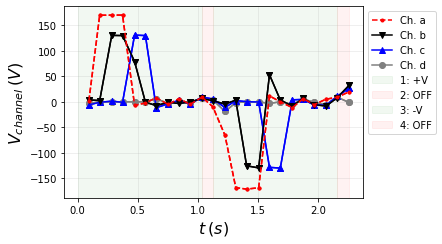

In [340]:
dict_seq = get_sequence(df_copy)
df = dict_seq['df']
plot_trace(df, dict_seq)

---

## Idealized Traces

### Inputs: OOO,CCC

In [362]:
t_dwell=100
t_step=1750
NumVSteps=1
NumPSteps=1

Vmax = 1
t_pause = 100

Sequence: OpenOpenOpenCloseCloseClose

NOTE:
* this is a "unit" sequence so y-axis is normalized from 0 to 1 and there are no 'steps'
* because there are no 'steps', this sequence cannot be analyzed like a .trc
* currently, x-axis is dimensional
* x-axis can be made non-dimensional by making t_dwell = 1 (then each time point is a "unit" of time = dwell)

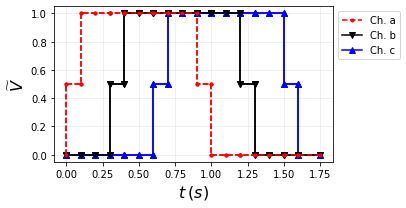

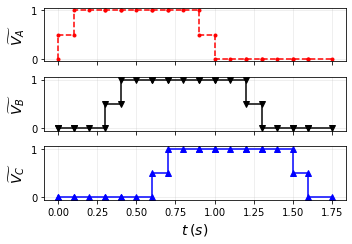

In [361]:
df = sequence_ooo_ccc(t_dwell, t_step, NumVSteps, NumPSteps)

plot_overlay_ideal_trace(df)

plot_ideal_trace(df)

---

Full Sequence (V+, Pause, V-, Pause): OpenOpenOpenCloseCloseClose

NOTE: this is a dimensional sequence so y-axis is scaled by Vmax

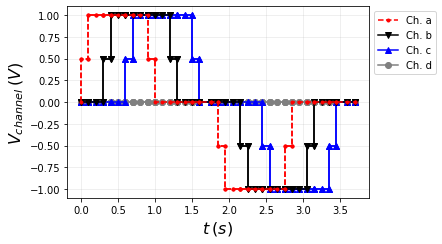

In [363]:
df = sequence_ooo_ccc_Vpm(Vmax, t_pause, t_dwell, t_step, NumVSteps, NumPSteps)

plot_trace(df, dict_seq=None)

---

## Inputs: OO,C-O,CC

In [366]:
Vmax = 1
t_dwell=100
t_step=1000
t_pause = 100

Unit Sequence: OpenOpen,Close-Open,CloseClose

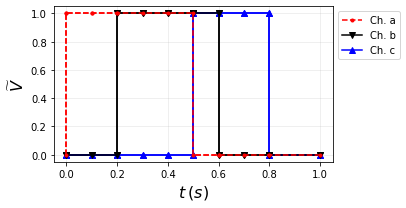

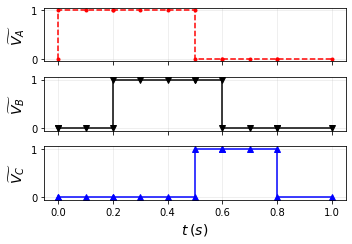

In [367]:
df = sequence_oo_co_cc(t_dwell, t_step)  

plot_overlay_ideal_trace(df)

plot_ideal_trace(df)

---

Full Sequence: OO,C-O,CC

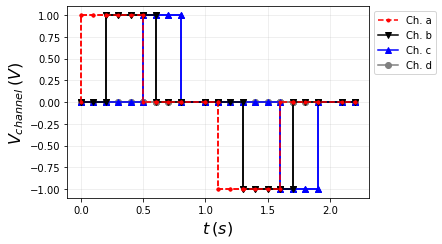

In [368]:
df = sequence_oo_co_cc_Vpm(Vmax, t_pause, t_dwell, t_step)

plot_trace(df, dict_seq=None)

---

---

# Working Space

Use the area below to analyze data and generate figures

### Experimental Traces

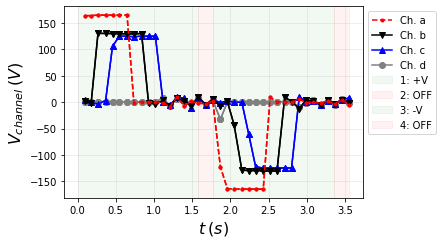

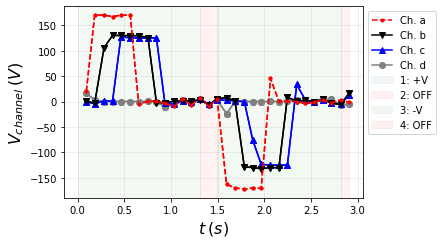

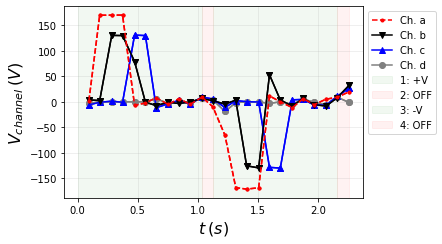

In [317]:
base_path = '/Users/mackenzie/Desktop/PASSM17/traces'
files = [f for f in os.listdir(base_path) if f.endswith('.trc')]

for f in files:
    filepath = join(base_path, f)  # 'HVSMeas240901-2220_P4.trc'
    df = read_trace(filepath)
    
    dict_seq = get_sequence(df)
    df = dict_seq['df']
    
    plot_trace(df, dict_seq, path_save=join(base_path, 'figs', f[:-4]))

## Idealized: OOO,CCC

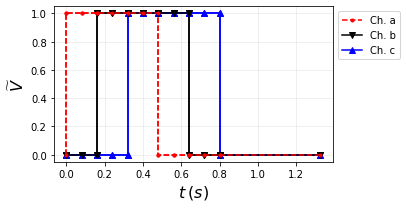

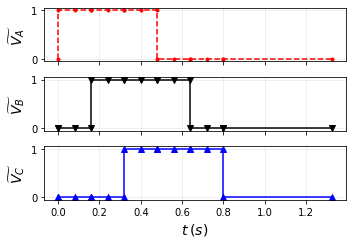

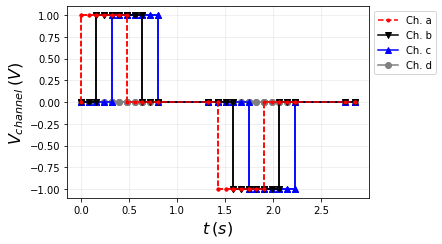

In [370]:
path_save_ = '/Users/mackenzie/Desktop/PASSM17/traces/figs'

id_ = 'P3'
Vmax = 1
t_dwell=80
t_step=1325
t_pause = 100
NumVSteps = 0
NumPSteps = 1

# save directory
path_save_ = join(path_save_, id_)
if not os.path.exists(path_save_):
    os.makedirs(path_save_)
    
# export settings for later reference
export_settings(id_, t_dwell, t_step, t_pause, path_save=join(path_save_, id_ + '_sequence-settings.xlsx'))

# unit sequence
df = sequence_ooo_ccc(t_dwell, t_step, NumVSteps, NumPSteps)
df.to_excel(join(path_save_, id_ + '_sequence-unit.xlsx'))
plot_overlay_ideal_trace(df, path_save=join(path_save_, id_ + '_sequence-unit.png'))
plot_ideal_trace(df, path_save=join(path_save_, id_ + '_channels.png'))

# bipolar sequence
df = sequence_ooo_ccc_Vpm(Vmax, t_pause, t_dwell, t_step, NumVSteps, NumPSteps)
df.to_excel(join(path_save_, id_ + '_sequence-bipolar.xlsx'))
plot_trace(df, dict_seq=None, path_save=join(path_save_, id_ + '_sequence-bipolar.png'))

## Idealized: OO,C-O,CC

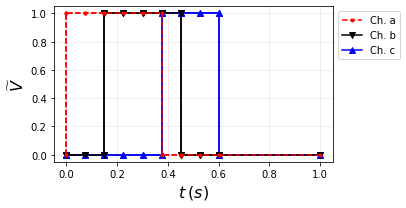

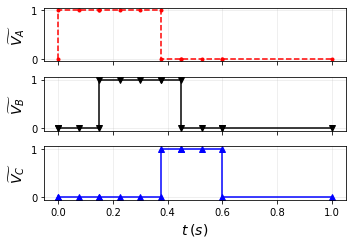

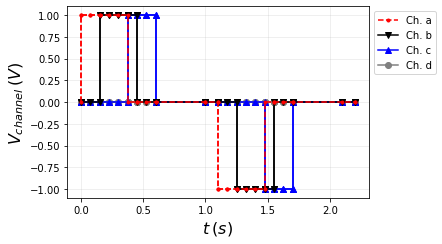

In [369]:
path_save_ = '/Users/mackenzie/Desktop/PASSM17/traces/figs'

id_ = 'P4'
Vmax = 1
t_dwell = 75
t_step = 1000
t_pause = 100

# save directory
path_save_ = join(path_save_, id_)
if not os.path.exists(path_save_):
    os.makedirs(path_save_)
    
# export settings for later reference
export_settings(id_, t_dwell, t_step, t_pause, path_save=join(path_save_, id_ + '_sequence-settings.xlsx'))

# unit sequence
df = sequence_oo_co_cc(t_dwell, t_step) 
df.to_excel(join(path_save_, id_ + '_sequence-unit.xlsx'))
plot_overlay_ideal_trace(df, path_save=join(path_save_, id_ + '_sequence-unit.png'))
plot_ideal_trace(df, path_save=join(path_save_, id_ + '_channels.png'))

# bipolar sequence
df = sequence_oo_co_cc_Vpm(Vmax, t_pause, t_dwell, t_step)
df.to_excel(join(path_save_, id_ + '_sequence-bipolar.xlsx'))
plot_trace(df, dict_seq=None, path_save=join(path_save_, id_ + '_sequence-bipolar.png'))

---

---

# Merge experimental and ideal (OOO,CCC)

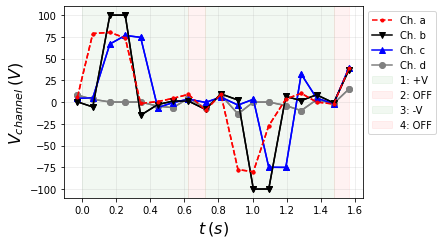

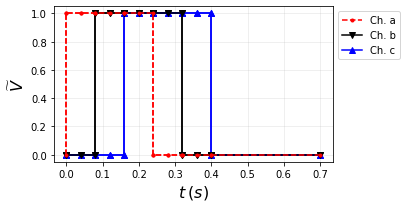

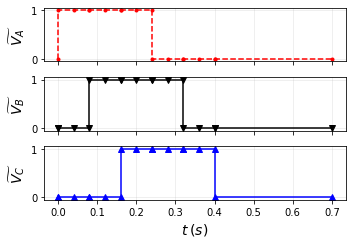

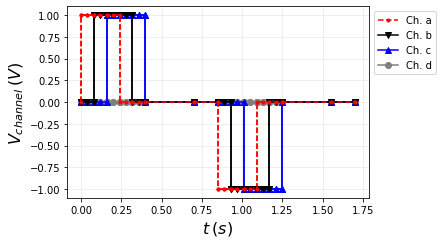

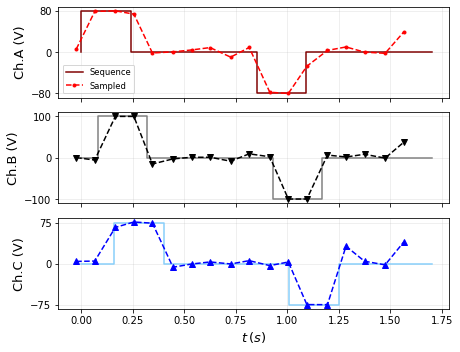

In [414]:
base_path = '/Users/mackenzie/Desktop/PASSM15/traces_01.08.24'
path_save_ = join(base_path, 'figs')

# settings
fn = 'HVSMeas240801-2032_P64.trc'
id_ = 'P64'

Va, Vb, Vc = 80, 100, 75
t_dwell = 40
t_step = 700
t_pause = 150
NumVSteps = 0
NumPSteps = 1
Vmax = 1
sampling_period = 0.0256 * -1

# ----------------------------------------------------------------------

# save directory
path_save_ = join(path_save_, id_)
if not os.path.exists(path_save_):
    os.makedirs(path_save_)
    
# export settings for later reference
export_settings(id_, t_dwell, t_step, t_pause, path_save=join(path_save_, id_ + '_sequence-settings.xlsx'))

# ---
# experimental

dfexp = read_trace(join(base_path, fn))
dict_seq = get_sequence(dfexp, sampling_period=sampling_period)
dfexp = dict_seq['df']

dfexp.to_excel(join(path_save_, id_ + '_sequence-experimental.xlsx'))
plot_trace(dfexp, dict_seq, path_save=join(path_save_, fn[:-4]))

# ---
# ideal

# unit sequence
df = sequence_ooo_ccc(t_dwell, t_step, NumVSteps, NumPSteps)
df.to_excel(join(path_save_, id_ + '_sequence-unit.xlsx'))
plot_overlay_ideal_trace(df, path_save=join(path_save_, id_ + '_sequence-unit.png'))
plot_ideal_trace(df, path_save=join(path_save_, id_ + '_channels.png'))

# bipolar sequence
dfseq = sequence_ooo_ccc_Vpm(Vmax, t_pause, t_dwell, t_step, NumVSteps, NumPSteps)
plot_trace(dfseq, dict_seq=None, path_save=join(path_save_, id_ + '_sequence-bipolar.png'))

# ---

# map ideal sequence onto experimental trace
for ch, Vmax in zip(['Va', 'Vb', 'Vc'], [Va, Vb, Vc]):
    dfseq[ch] = dfseq[ch] * Vmax
dfseq.to_excel(join(path_save_, id_ + '_sequence-bipolar.xlsx'))
plot_exp_and_ideal_trace(dfexp, dfseq, path_save=join(path_save_, id_ + '_overlay_exp_and_ideal.png'))

---

---

# Merge experimental and ideal (OO,C-O,CC)

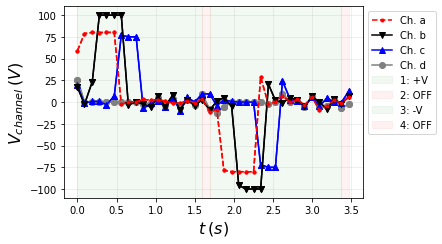

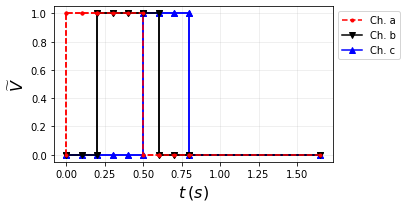

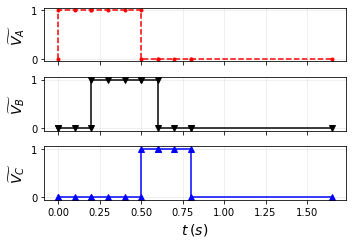

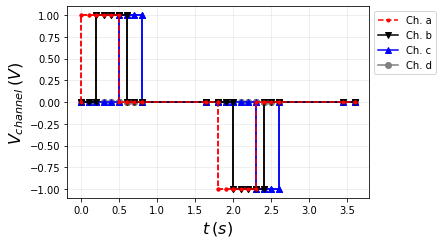

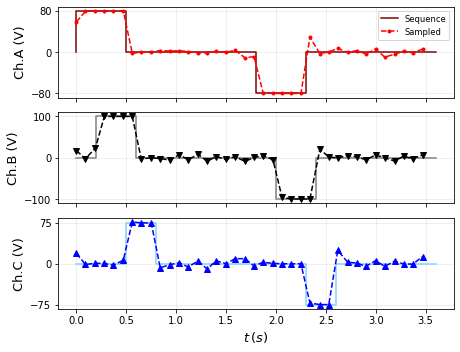

In [412]:
base_path = '/Users/mackenzie/Desktop/PASSM15/traces_01.08.24'
path_save_ = join(base_path, 'figs')

# settings
fn = 'HVSMeas240801-2059_P66.trc'
id_ = 'P66'

Va, Vb, Vc = 80, 100, 75
t_dwell = 100
t_step = 1650
t_pause = 150
Vmax = 1
sampling_period = 0.0256 * 0

# save directory
path_save_ = join(path_save_, id_)
if not os.path.exists(path_save_):
    os.makedirs(path_save_)

# export settings for later reference
export_settings(id_, t_dwell, t_step, t_pause, path_save=join(path_save_, id_ + '_sequence-settings.xlsx'))

# ---

# experimental
filepath = join(base_path, fn)
dfexp = read_trace(filepath)

dict_seq = get_sequence(dfexp, sampling_period=sampling_period)
dfexp = dict_seq['df']

dfexp.to_excel(join(path_save_, id_ + '_sequence-experimental.xlsx'))
plot_trace(dfexp, dict_seq, path_save=join(path_save_, fn[:-4]))

# ---

# ideal

# unit sequence
df = sequence_oo_co_cc(t_dwell, t_step) 
df.to_excel(join(path_save_, id_ + '_sequence-unit.xlsx'))
plot_overlay_ideal_trace(df, path_save=join(path_save_, id_ + '_sequence-unit.png'))
plot_ideal_trace(df, path_save=join(path_save_, id_ + '_channels.png'))

# bipolar sequence
dfseq = sequence_oo_co_cc_Vpm(Vmax, t_pause, t_dwell, t_step)
plot_trace(dfseq, dict_seq=None, path_save=join(path_save_, id_ + '_sequence-bipolar.png'))

# ---

# map ideal sequence onto experimental trace
for ch, Vmax in zip(['Va', 'Vb', 'Vc'], [Va, Vb, Vc]):
    dfseq[ch] = dfseq[ch] * Vmax
dfseq.to_excel(join(path_save_, id_ + '_sequence-bipolar.xlsx'))
plot_exp_and_ideal_trace(dfexp, dfseq, path_save=join(path_save_, id_ + '_overlay_exp_and_ideal.png'))